<h1>Analysis and Logistic Regression on the Titanic Dataset </h1>
<h3>In this notebook, I take a look at the titanic data, then use logistic regression to try to predict the survival of a passenger</h3>

In [84]:
import pandas as pd
import numpy as np
import math as math
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split as tts
from sklearn.linear_model import LogisticRegression

In [2]:
# Use pandas to open titanic.csv
df=pd.read_csv('titanic.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<h1>Quick summary of the data</h1>

In [3]:
round(df.describe(),3)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000,891.000,891.000,714.000,891.000,891.000,891.000
mean,446.000,0.384,2.309,29.699,0.523,0.382,32.204
std,257.354,0.487,0.836,14.526,1.103,0.806,49.693
min,1.000,0.000,1.000,0.420,0.000,0.000,0.000
25%,223.500,0.000,2.000,20.125,0.000,0.000,7.910
50%,446.000,0.000,3.000,28.000,0.000,0.000,14.454
75%,668.500,1.000,3.000,38.000,1.000,0.000,31.000
max,891.000,1.000,3.000,80.000,8.000,6.000,512.329


<h1>Check for missing values</h1>
First, want to determine the missing values, and perhaps replace them

In [4]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Looks like there are 3 places that contain missing values. Age, Cabin, and Embarked. The cabin and embarked columsn likely didnt matter, so let's just delete those columns

In [5]:
del df['Cabin']
del df['Embarked']

Now that the Cabin and embarked columns are gone, lets take a look at the Age column.

First, I will split the ages into 8 subgroups by 10 years (0-10, 10-20, ...) and split them by survived or did not survive

In [6]:
survived= []
not_survived = []
for ii in range(0,80,10):
    survived.append(len(df.loc[(df['Age'] > ii) &
                          (df['Age'] <=(ii+10)) &
                          (df['Survived'] == 1)]))
    not_survived.append(len(df.loc[(df['Age'] > ii) &
                          (df['Age'] <=(ii+10)) &
                          (df['Survived'] == 0)]))
sum(survived + not_survived)

714

In [7]:
survived

[38, 44, 84, 69, 33, 17, 4, 1]

In [8]:
not_survived

[26, 71, 146, 86, 53, 25, 13, 4]

Then I also prepare the x-axis

In [9]:
ages = ('0-10','10-20','20-30', '30-40',
       '40-50','50-60', '60-70', '70-80')


Now I create the plot

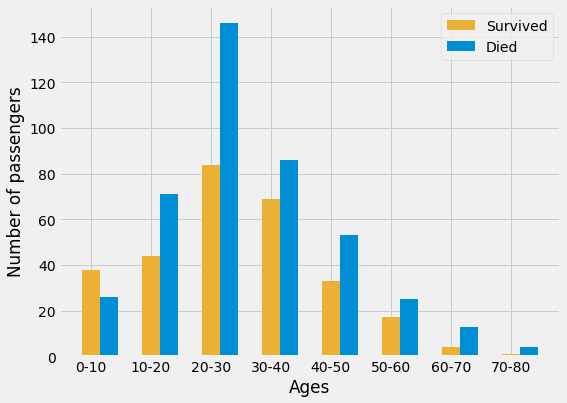

In [109]:
# plot style
plt.style.use("fivethirtyeight")

# Subplot
fig, ax = plt.subplots(figsize = (8,6))

# plot width and managing x_indexes
width = .3
x_indexes = np.arange(len(ages))

# plotting
ax.bar(x_indexes, survived, width = width, label = 'Survived', color = '#ebb134')
ax.bar(x_indexes + width, not_survived, width = width, label = 'Died')

# final touches
plt.legend()
plt.xticks(ticks = x_indexes, labels = ages)
plt.xlabel('Ages')
plt.ylabel('Number of passengers')
plt.show()

Seems like Age does have a huge effect on the survivability of a passenger. Additionally, the graph is slightly right skewed. So let's fill in the null values in our df column with the median

In [11]:
df['Age'] = df['Age'].fillna(df['Age'].median())
df.Age.isnull().sum()

0

<h1> More data touchups </h1>

It also seems like the covariates 'Name' and 'Ticket' have no impact, so lets remove those

In [12]:
del df['Name']
del df['Ticket']

Let's also now make sex a categorical value, so its easier to process

In [13]:
#Make Sex a categorical Variable, and delete Sex
df['isMale']=np.where(df['Sex']=='male',1,0)
del df['Sex']

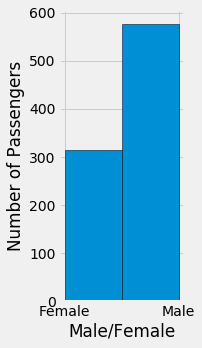

In [44]:
fig2, ax2 = plt.subplots(figsize = (2,5))
ax2.hist(df['isMale'], bins = 2, edgecolor = 'black', align = 'mid')
plt.xticks([0,1],('Female','Male'))
plt.xlabel('Male/Female')
plt.ylabel('Number of Passengers')
plt.show()

In [14]:
df.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,isMale
0,1,0,3,22.0,1,0,7.2500,1
1,2,1,1,38.0,1,0,71.2833,0
2,3,1,3,26.0,0,0,7.9250,0
3,4,1,1,35.0,1,0,53.1000,0
4,5,0,3,35.0,0,0,8.0500,1


Take a look at the passenger class

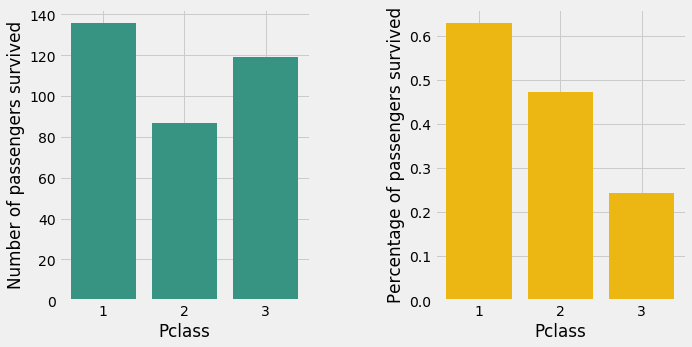

In [81]:
# get plot data
pclass_survived = [0,0,0]
pclass_survived_percentage = [0,0,0]
for i in range(0,3):
    pclass_survived[i] = len(df.loc[ (df['Pclass'] ==i+1) & (df['Survived'] == 1) ])
    pclass_survived_percentage[i] = pclass_survived[i] / len(df.loc[ (df['Pclass'] == i+1)])
pclass = ['1','2','3']

# Set up subplots, and plot the data
fi3, (ax3_1, ax3_2) = plt.subplots(ncols = 2, figsize = (10,5))
plt.subplots_adjust(wspace = .5)
ax3_1.bar(pclass, pclass_survived, color = '#379483')
ax3_2.bar(pclass, pclass_survived_percentage, color = '#edb713')

# Add labels
ax3_1.set_xlabel('Pclass')
ax3_1.set_ylabel('Number of passengers survived')
ax3_2.set_xlabel('Pclass')
ax3_2.set_ylabel('Percentage of passengers survived')
plt.show()


<h1> Logistic Regression</h1>

Now that we have a good idea of some of the covariates and their relationships, let's apply logistic regression

Select the variables to use as predictors and the predicted

In [106]:
testVariables=["Pclass","Age","SibSp","Parch","Fare","isMale"]
predVariable = ["Survived"]

Set up train and test sets

In [107]:
x_train, x_test, y_train, y_test = tts(df[testVariables],df['Survived'],train_size=0.95)

Create the model

In [103]:
model = LogisticRegression(solver = 'liblinear')

Fit the model with our train set as defined above

In [108]:
model.fit(x_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

Now we check how well our model performs on our test set

In [105]:
# determine score
model.score(x_test,y_test)

0.8